# GA & GP optimization of NN

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import genetic_algorithm as ga
from nn_ga import GenAlgNN
from nn_gp import GenProgNN

## Generate and load data

In [15]:
from math import pi, sin, cos
theta = 0.5 * pi
while theta < 3.5 * pi:
    r = theta * 1.5 / pi
    x = r * sin(theta)
    y = r * cos(theta)
    print(f'{x:.6f},{y:.6f},1')
    print(f'{-x:.6f},{-y:.6f},-1')
    theta += 0.125 / r

0.750000,0.000000,1
-0.750000,-0.000000,-1
0.818082,-0.137624,1
-0.818082,0.137624,-1
0.856506,-0.281316,1
-0.856506,0.281316,-1
0.868843,-0.426148,1
-0.868843,0.426148,-1
0.858125,-0.568578,1
-0.858125,0.568578,-1
0.827030,-0.705980,1
-0.827030,0.705980,-1
0.777977,-0.836372,1
-0.777977,0.836372,-1
0.713175,-0.958250,1
-0.713175,0.958250,-1
0.634662,-1.070481,1
-0.634662,1.070481,-1
0.544318,-1.172224,1
-0.544318,1.172224,-1
0.443891,-1.262874,1
-0.443891,1.262874,-1
0.334999,-1.342021,1
-0.334999,1.342021,-1
0.219148,-1.409413,1
-0.219148,1.409413,-1
0.097735,-1.464936,1
-0.097735,1.464936,-1
-0.027944,-1.508584,1
0.027944,1.508584,-1
-0.156687,-1.540451,1
0.156687,1.540451,-1
-0.287380,-1.560706,1
0.287380,1.560706,-1
-0.418995,-1.569591,1
0.418995,1.569591,-1
-0.550583,-1.567401,1
0.550583,1.567401,-1
-0.681270,-1.554482,1
0.681270,1.554482,-1
-0.810254,-1.531220,1
0.810254,1.531220,-1
-0.936802,-1.498033,1
0.936802,1.498033,-1
-1.060243,-1.455366,1
1.060243,1.455366,-1
-1.179970,-

In [16]:
spiral = pd.read_csv('../two_spirals.csv', names=['x', 'y', 'class'])

In [17]:
X_valid = spiral.copy()
y_valid = X_valid.pop('class')

X_train = spiral.sample(frac=0.5)
y_train = X_train.pop('class')

In [18]:
X_valid

,x,y
0,0.750000,0.000000
1,-0.750000,-0.000000
2,0.818082,-0.137624
3,-0.818082,0.137624
4,0.856506,-0.281316
...,...,...
447,5.217540,0.275522
448,-5.234056,-0.150959
449,5.234056,0.150959
450,-5.247566,-0.026036


In [19]:
y_valid

0      1
1     -1
2      1
3     -1
4      1
      ..
447   -1
448    1
449   -1
450    1
451   -1
Name: class, Length: 452, dtype: int64

In [20]:
X_train

,x,y
442,-5.175502,-0.523279
269,-3.135712,2.612968
119,1.273374,-2.462354
439,5.121496,0.768717
450,-5.247566,-0.026036
...,...,...
387,3.404528,3.481758
0,0.750000,0.000000
82,-2.298608,0.492539
271,-3.065175,2.717457


In [21]:
y_train

442    1
269   -1
119   -1
439   -1
450    1
      ..
387   -1
0      1
82     1
271   -1
280    1
Name: class, Length: 226, dtype: int64

## Visualisation utilities

In [22]:
def visualize_model(model):
    global X_train, y_train
    points = np.zeros([120, 120, 2])
    for y in range(120):
        for x in range(120):
            points[y, x, 0] = (x - 60) / 10.0
            points[y, x, 1] = (y - 60) / 10.0
    plt.imshow(model.predict(points.reshape([-1, 2])).reshape([120, 120]), cmap='cividis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.axis('off')
    points = X_train.where(y_train > 0) * 10 + 60
    plt.scatter(points['x'], points['y'], c='red')
    points = X_train.where(y_train < 0) * 10 + 60
    plt.scatter(points['x'], points['y'], c='limegreen')
    plt.show()

In [23]:
def print_population(fitnesses, population):
    arr = [(1.0 / f - 1.0, i) for f, i in zip(fitnesses, population)]
    arr.sort(key=lambda t: t[0])
    for m, i in arr:
        print(f'mse={m:.4f} {i}')
    return arr

## Test NN

In [24]:
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.03))
model.fit(np.array(X_train), np.array(y_train), epochs=2000, batch_size=8, verbose=0)
keras.losses.MeanSquaredError()(y_valid, model.predict(X_valid)).numpy()

1.7034707

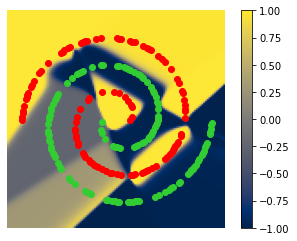

In [25]:
visualize_model(model)

## Genetic Algorithm

In [26]:
problem_ga = GenAlgNN((np.array(X_train), np.array(y_train)), (np.array(X_valid), np.array(y_valid)))
ga_optimizer = ga.GAOptimizer(problem_ga)

In [27]:
ga_optimizer.start(8)
for i in range(6):
    old_population = ga_optimizer.population
    gen, old_fitnesses = ga_optimizer.next_generation()
    print_population(old_fitnesses, old_population)
    print('=== New generation ===', i)

mse=1.2293 [4, 2, 5, 4]
mse=1.3794 [1, 2, 1, 0]
mse=1.4912 [1, 0, 2, 7]
mse=1.6637 [0, 7, 7, 7]
mse=1.7207 [8, 3, 5, 0]
mse=1.8069 [4, 5, 5, 7]
mse=1.8135 [4, 1, 6, 1]
mse=1.8969 [1, 0, 6, 3]
=== New generation === 0
mse=1.1985 [1, 0, 2, 4]
mse=1.2260 [1, 2, 1, 0]
mse=1.2712 [1, 0, 2, 7]
mse=1.3389 [1, 2, 0, 0]
mse=1.8215 [4, 2, 5, 0]
mse=1.8599 [4, 1, 5, 1]
mse=1.9032 [8, 3, 6, 0]
mse=1.9083 [8, 3, 5, 4]
=== New generation === 1
mse=1.5198 [4, 2, 5, 0]
mse=1.6833 [4, 1, 5, 1]
mse=1.7846 [4, 1, 5, 1]
mse=1.8620 [8, 3, 5, 4]
mse=1.8932 [4, 1, 5, 1]
mse=1.9000 [8, 3, 5, 4]
mse=1.9045 [8, 3, 5, 4]
mse=1.9108 [8, 3, 5, 4]
=== New generation === 2
mse=1.6232 [4, 3, 5, 4]
mse=1.7268 [4, 1, 5, 1]
mse=1.7730 [8, 1, 5, 4]
mse=1.7888 [4, 8, 5, 1]
mse=1.8269 [4, 3, 5, 1]
mse=1.8856 [8, 3, 5, 4]
mse=1.9088 [8, 3, 5, 4]
mse=1.9434 [8, 1, 1, 7]
=== New generation === 3
mse=1.6091 [8, 1, 5, 7]
mse=1.6840 [8, 3, 5, 4]
mse=1.6867 [8, 3, 1, 4]
mse=1.7017 [8, 3, 5, 4]
mse=1.8487 [4, 3, 5, 1]
mse=1.8614 [

In [28]:
fitnesses = [problem_ga.fitness(i) for i in gen]
mse = print_population(fitnesses, gen)

mse=1.3530 [6, 1, 5, 4]
mse=1.7008 [8, 7, 5, 5]
mse=1.7418 [5, 7, 5, 4]
mse=1.7850 [6, 3, 5, 4]
mse=1.8033 [8, 1, 5, 7]
mse=1.8297 [8, 8, 5, 5]
mse=1.8685 [8, 3, 5, 7]
mse=1.9447 [8, 7, 5, 5]


In [ ]:
problem_ga.epochs = 4000
model = problem_ga.train_nn(mse[0][1])
keras.losses.MeanSquaredError()(y_valid, model.predict(X_valid)).numpy()

In [ ]:
visualize_model(model)

## Genetic Programming

In [ ]:
problem_gp = GenProgNN((np.array(X_train), np.array(y_train)), (np.array(X_valid), np.array(y_valid)))
gp_optimizer = ga.GAOptimizer(problem_gp)

In [ ]:
gp_optimizer.start(10)
for i in range(8):
    old_population = gp_optimizer.population
    gen, old_fitnesses = gp_optimizer.next_generation()
    print_population(old_fitnesses, old_population)
    print('=== New generation ===', i)

In [ ]:
fitnesses = [problem_gp.fitness(i) for i in gen]
mse = print_population(fitnesses, gen)

In [ ]:
problem_gp.epochs = 4000
model = problem_gp.train_nn(mse[0][1])
keras.losses.MeanSquaredError()(y_valid, model.predict(X_valid)).numpy()

In [ ]:
visualize_model(model)

In [ ]:
for item in mse:
    print('digraph {')
    print(item[1].to_dot())
    print('}')
    print()